# MOFA+

In [52]:
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

In [53]:
save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"
rna_adata_pool = ad.read_h5ad(f"{save_path}/rna_pool.h5ad")
# protein_adata_pool = ad.read_h5ad(f"{save_path}/protein_pool.h5ad")
protein_adata_intersect = ad.read_h5ad(f"{save_path}/scCITE_intersect_protein.h5ad")

In [54]:
rna_adata_pool_subset = rna_adata_pool[:, rna_adata_pool.var["highly_variable"]]
rna_adata_pool_subset = rna_adata_pool_subset[:, 
        rna_adata_pool_subset.var.sort_values(by="highly_variable_rank").index]

In [55]:
mdata = mu.MuData({
    "rna": rna_adata_pool_subset,
    "protein": protein_adata_intersect,
})
mdata

MuData object with n_obs × n_vars = 32648 × 4110
  2 modalities
    rna:	32648 x 4000
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	32648 x 110
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p'
      layers:	'counts'

In [56]:
prot = mdata.mod['protein']
sc.tl.pca(prot)
sc.pp.neighbors(prot)
sc.tl.umap(prot, random_state=1)

In [57]:
rna = mdata.mod['rna']
rna.X = rna.layers["counts"].copy()
sc.pp.log1p(rna)
sc.pp.scale(rna)
# sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)

/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [58]:
sc.tl.pca(rna, svd_solver='arpack')
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)
sc.tl.leiden(rna, resolution=.75)
sc.tl.umap(rna, spread=1., min_dist=.5, random_state=11)

In [59]:
mu.pp.intersect_obs(mdata)
# mu.tl.louvain(mdata, resolution=[2, .1], random_state=1)
mu.tl.leiden(mdata, resolution=[2, .1], random_state=1)

/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


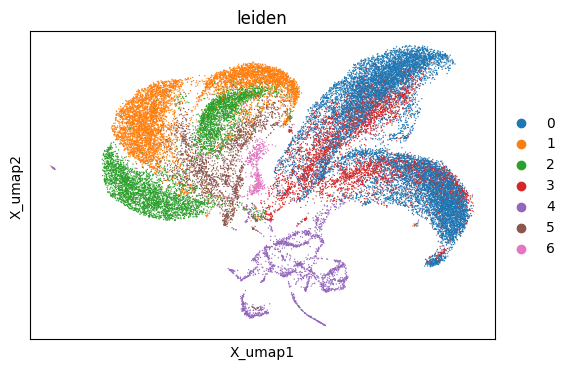

In [60]:
mu.pl.embedding(mdata, basis="rna:X_umap", color=["leiden"])
prot.var["highly_variable"] = True
# rna.var["highly_variable"] = True
mdata.update()

In [61]:
mdata.var["highly_variable"] = mdata.var["highly_variable"].astype(bool).to_list()

# mu.pp.intersect_var(mdata)

In [62]:
# Generate five different random subsample datasets from the original dataset
import numpy as np
import random
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from models.utils import measurement_mixing_metric

random.seed(42)

num_cells = mdata.shape[0]
subsample_size = 10000
subsample_datasets = []

for i in range(5):
    subsample_indices = random.sample(range(num_cells), subsample_size)
    subsample_data = mdata[subsample_indices, :].copy()
    subsample_datasets.append(subsample_data)

In [63]:
# adata_subset.varm["LFs"], adata_subset.var["highly_variable"]
# adata_subset.varm["LFs"][adata_subset.var["highly_variable"].values.tolist()]
# mdata.var["highly_variable"].values

In [66]:
silhouette_score_dict = {}
calinski_harabasz_score_dict = {}
davies_bouldin_score_dict = {}
mixing_metric_dict = {}
for i, adata_subset in enumerate(subsample_datasets):
    mu.tl.mofa(adata_subset, n_factors=30, use_var="highly_variable", 
               gpu_mode=False, save_data=False, save_metadata=False)
    sc.pp.neighbors(adata_subset, use_rep="X_mofa")
    sc.tl.umap(adata_subset, random_state=1)
    embedding = adata_subset.obsm["X_umap"]
    silhouette_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []
    mixing_metrics = []
    for k in range(2, 30):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(embedding)
        silhouette_scores.append(silhouette_score(embedding, labels))
        calinski_harabasz_scores.append(calinski_harabasz_score(embedding, labels))
        davies_bouldin_scores.append(davies_bouldin_score(embedding, labels))
        mixing_metrics.append(measurement_mixing_metric(embedding, labels))
    silhouette_score_dict[f"Subset_{i}"] = silhouette_scores
    calinski_harabasz_score_dict[f"Subset_{i}"] = calinski_harabasz_scores
    davies_bouldin_score_dict[f"Subset_{i}"] = davies_bouldin_scores
    mixing_metric_dict[f"Subset_{i}"] = mixing_metrics


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


Loaded view='rna' group='group1' with N=10000 samples and D=4000 features...
Loaded view='protein' group='group1' with N=10000 samples and D=110 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (rna): gaussian
- View 1 (protein): gaussian




######################################
## Training the model with seed 1 ##
######################################



Converged!



#######################
## Training finished ##
#######################


Saving model in /tmp/mofa_20240526-225020.hdf5...
Saved MOFA embeddings in .obsm['X_mofa'] slot and their loadings in .varm['LFs'].

        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
 

In [ ]:
# save the silhouette scores dict
import pickle

with open(f"{save_path}mofa_silhouette_scores_dict.pkl", "wb") as f:
    pickle.dump(silhouette_score_dict, f)

with open(f"{save_path}mofa_calinski_harabasz_scores_dict.pkl", "wb") as f:
    pickle.dump(calinski_harabasz_score_dict, f)

with open(f"{save_path}mofa_davies_bouldin_scores_dict.pkl", "wb") as f:
    pickle.dump(davies_bouldin_score_dict, f)

with open(f"{save_path}mofa_mixing_metric_dict.pkl", "wb") as f:
    pickle.dump(mixing_metric_dict, f)

In [ ]:
import pickle
# load the silhouette scores dict
tmp = pickle.load(open(f"{save_path}mofa_silhouette_scores_dict.pkl", "rb"))

In [ ]:
tmp.keys()

dict_keys(['Subset_0', 'Subset_1', 'Subset_2', 'Subset_3', 'Subset_4'])

# WNN

In [16]:
from sklearn.cluster import KMeans

silouette_scores_dict = {}
for i, dataset in enumerate(subsample_datasets):
    sc.pp.neighbors(dataset["rna"])
    sc.pp.neighbors(dataset["protein"])
    mu.pp.neighbors(dataset, key_added="wnn")
    mu.tl.umap(dataset, neighbors_key="wnn")
    embeddings = dataset.obsm["X_umap"]

    # using the neighbors and KNN graph to calculate the silhouette score
    silhouette_scores = []
    for num_cluster in range(2, 30):
        adj_mtx = dataset.obsp["wnn_connectivities"]
        kmeans = KMeans(n_clusters=num_cluster, random_state=42, n_init=10)
        kmeans.fit(adj_mtx)  # Use adjacency matrix as input for k-means
        cluster_labels = kmeans.labels_
        silhouette_scores.append(silhouette_score(embeddings, cluster_labels))
    silouette_scores_dict[f"Subset_{i}"] = silhouette_scores

In [17]:
silouette_scores_dict.keys()

dict_keys(['Subset_0', 'Subset_1', 'Subset_2', 'Subset_3', 'Subset_4'])

In [19]:
# save the silouette scores dict
import pickle

with open(f"{save_path}wnn_silhouette_scores_dict.pkl", "wb") as f:
    pickle.dump(silouette_scores_dict, f)

In [22]:
tmp = pickle.load(open(f"{save_path}wnn_silhouette_scores_dict.pkl", "rb"))
tmp.keys()

dict_keys(['Subset_0', 'Subset_1', 'Subset_2', 'Subset_3', 'Subset_4'])

# TotalVI

In [1]:
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"
rna_adata_pool = ad.read_h5ad(f"{save_path}/rna_pool.h5ad")
# protein_adata_pool = ad.read_h5ad(f"{save_path}/protein_pool.h5ad")
protein_adata_intersect = ad.read_h5ad(f"{save_path}/scCITE_intersect_protein.h5ad")

In [3]:
rna_adata_pool_subset = rna_adata_pool[:, rna_adata_pool.var["highly_variable"]]
rna_adata_pool_subset = rna_adata_pool_subset[:, 
        rna_adata_pool_subset.var.sort_values(by="highly_variable_rank").index]

In [4]:
mdata = mu.MuData({
    "rna": rna_adata_pool_subset,
    "protein": protein_adata_intersect,
})
mdata

MuData object with n_obs × n_vars = 32648 × 4110
  2 modalities
    rna:	32648 x 4000
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	32648 x 110
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p'
      layers:	'counts'

In [5]:
# Generate five different random subsample datasets from the original dataset
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


random.seed(42)

num_cells = mdata.shape[0]
subsample_size = 10000
subsample_datasets = []

for i in range(5):
    subsample_indices = random.sample(range(num_cells), subsample_size)
    subsample_data = mdata[subsample_indices, :].copy()
    subsample_datasets.append(subsample_data)

In [6]:
import scvi

silhouette_score_dict = {}
for i, adata_subset in enumerate(subsample_datasets):
    scvi.model.TOTALVI.setup_mudata(
        adata_subset,
        rna_layer="counts",
        protein_layer="counts",
        modalities={
            "rna_layer": "rna",
            "protein_layer": "protein",
        },
    )
    model = scvi.model.TOTALVI(adata_subset)
    model.train()
    embeddings = model.get_latent_representation()
    silhouette_scores = []
    for k in range(2, 30):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(embeddings)
        silhouette_scores.append(silhouette_score(embeddings, labels))
    silhouette_score_dict[f"Subset_{i}"] = silhouette_scores

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
CUDA backend failed to initialize: Found CUDA version 11070, but JAX was built against version 11080, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     Computing empirical prior initialization for protein background.                                          


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/lightning/pytorch/core/optimizer.py:321: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  rank_zero_warn(


Epoch 380/400:  95%|█████████▌| 380/400 [06:49<00:21,  1.08s/it, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.5e+3] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1533.056. Signaling Trainer to stop.
INFO     Computing empirical prior initialization for protein background.                                          


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/lightning/pytorch/core/optimizer.py:321: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [07:46<00:00,  1.38s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [07:46<00:00,  1.17s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.5e+3]
INFO     Computing empirical prior initialization for protein background.                                          


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/lightning/pytorch/core/optimizer.py:321: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [06:52<00:00,  1.11s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.51e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [06:52<00:00,  1.03s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.51e+3]
INFO     Computing empirical prior initialization for protein background.                                          


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/lightning/pytorch/core/optimizer.py:321: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [06:29<00:00,  1.03s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.5e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [06:29<00:00,  1.03it/s, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.5e+3]
INFO     Computing empirical prior initialization for protein background.                                          


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/lightning/pytorch/core/optimizer.py:321: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  rank_zero_warn(


Epoch 314/400:  78%|███████▊  | 314/400 [05:16<01:26,  1.01s/it, v_num=1, train_loss_step=1.4e+3, train_loss_epoch=1.5e+3] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1564.848. Signaling Trainer to stop.


In [8]:
import pickle

with open(f"{save_path}scvi_silhouette_scores_dict.pkl", "wb") as f:
    pickle.dump(silhouette_score_dict, f)

In [9]:
tmp = pickle.load(open(f"{save_path}scvi_silhouette_scores_dict.pkl", "rb"))
tmp.keys()

dict_keys(['Subset_0', 'Subset_1', 'Subset_2', 'Subset_3', 'Subset_4'])

# GCAT

In [1]:
import muon as mu
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import torch

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"
rna_adata_pool = ad.read_h5ad(f"{save_path}/rna_pool.h5ad")
# protein_adata_pool = ad.read_h5ad(f"{save_path}/protein_pool.h5ad")
protein_adata_intersect = ad.read_h5ad(f"{save_path}/scCITE_intersect_protein.h5ad")

In [3]:
rna_adata_pool_subset = rna_adata_pool[:, rna_adata_pool.var["highly_variable"]]
rna_adata_pool_subset = rna_adata_pool_subset[:, 
        rna_adata_pool_subset.var.sort_values(by="highly_variable_rank").index]

In [4]:
mdata = mu.MuData({
    "rna": rna_adata_pool_subset,
    "protein": protein_adata_intersect,
})
mdata

MuData object with n_obs × n_vars = 32648 × 4110
  2 modalities
    rna:	32648 x 4000
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	32648 x 110
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p'
      layers:	'counts'

In [5]:
from models.dataset import create_graphData_mu, split_data

num_splits = 1
num_val = 0.2
num_test = 0.2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

# graph_data = create_graphData(rna_adata_pool_subset, protein_adata_intersect, device)
graph_data, rna_input_dim, prot_input_dim = create_graphData_mu(mdata, spatial_basis="expression")
training_data = split_data(graph_data, num_splits=num_splits, num_val=num_val, num_test=num_test)

In [6]:
from models.train import Trainer

model_choice = "Graph Cross Attention"

hidden_dim = 128
embedding_dim = 128
heads = 4
num_blocks = 2
permute = True
preserve_rate = 0.8
alpha = 0.3
beta = 0.1
lambda_reg = 1e-5

# setting for the trainer
batch_size = 512
lr = 1e-4
epochs = 20
mask_ratio = 0.85
GAT_encoding = False
return_attention_weights = False

trainer = Trainer(
    training_data,
    model_choice=model_choice,
    rna_input_dim=rna_input_dim,
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks,
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=mask_ratio,
    permute=permute,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
    lambda_reg=lambda_reg,
    GAT_encoding=GAT_encoding,
    return_attention_weights=False,
)

trainer.train(plot_loss=False)

Epoch 1/20 train_loss: 394.44334 val_loss: 52.99849
Epoch 2/20 train_loss: 151.58931 val_loss: 23.13283
Epoch 3/20 train_loss: 117.89227 val_loss: 22.07930
Epoch 4/20 train_loss: 116.40670 val_loss: 21.71127
Epoch 5/20 train_loss: 114.96714 val_loss: 20.95150
Epoch 6/20 train_loss: 111.71988 val_loss: 19.67101
Epoch 7/20 train_loss: 108.22935 val_loss: 18.91230
Epoch 8/20 train_loss: 106.85866 val_loss: 18.78321
Epoch 9/20 train_loss: 106.45408 val_loss: 18.70815
Epoch 10/20 train_loss: 106.06787 val_loss: 18.59585
Epoch 11/20 train_loss: 105.45240 val_loss: 18.24163
Epoch 12/20 train_loss: 104.82585 val_loss: 17.98949
Epoch 13/20 train_loss: 104.36496 val_loss: 17.67770
Epoch 14/20 train_loss: 103.47088 val_loss: 17.61771
Epoch 15/20 train_loss: 102.87267 val_loss: 17.44616
Epoch 16/20 train_loss: 102.50508 val_loss: 17.38656
Epoch 17/20 train_loss: 102.18827 val_loss: 17.34570
Epoch 18/20 train_loss: 101.67986 val_loss: 17.19277
Epoch 19/20 train_loss: 101.58669 val_loss: 17.10429
Ep

In [7]:
# Generate five different random subsample datasets from the original dataset
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


random.seed(42)

num_cells = mdata.shape[0]
subsample_size = 10000
subsample_datasets = []

for i in range(5):
    subsample_indices = random.sample(range(num_cells), subsample_size)
    subsample_data = mdata[subsample_indices, :].copy()
    subsample_datasets.append(subsample_data)

In [8]:
silhouette_score_dict = {}
for i, subset_mdata in enumerate(subsample_datasets):
    graph_subset_data, _, _ = create_graphData_mu(subset_mdata, spatial_basis="expression", 
                                                  features_use="all", device=device)
    embeddings = trainer.get_embedding(graph_subset_data)
    silhouette_scores = []
    for k in range(2, 30):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(embeddings)
        silhouette_scores.append(silhouette_score(embeddings, labels))
    silhouette_score_dict[f"Subset_{i}"] = silhouette_scores

Data(x=[10000, 4110], edge_index=[2, 42652])
Data(x=[10000, 4110], edge_index=[2, 42468])
Data(x=[10000, 4110], edge_index=[2, 42974])
Data(x=[10000, 4110], edge_index=[2, 42352])
Data(x=[10000, 4110], edge_index=[2, 42388])


In [9]:
import pickle

with open(f"{save_path}gcat_silhouette_scores_dict.pkl", "wb") as f:
    pickle.dump(silhouette_score_dict, f)

In [10]:
tmp = pickle.load(open(f"{save_path}gcat_silhouette_scores_dict.pkl", "rb"))
tmp.keys()

dict_keys(['Subset_0', 'Subset_1', 'Subset_2', 'Subset_3', 'Subset_4'])

# MAXFuse

In [1]:
import numpy as np
import pandas as pd
from scipy.io import mmread

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import anndata as ad
import scanpy as sc
import maxfuse as mf

/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"
rna_adata_pool = ad.read_h5ad(f"{save_path}/rna_pool.h5ad")
# protein_adata_pool = ad.read_h5ad(f"{save_path}/protein_pool.h5ad")
protein_adata_intersect = ad.read_h5ad(f"{save_path}/scCITE_intersect_protein.h5ad")

In [3]:
rna_adata_pool_subset = rna_adata_pool[:, rna_adata_pool.var["highly_variable"]]
rna_adata_pool_subset = rna_adata_pool_subset[:, 
        rna_adata_pool_subset.var.sort_values(by="highly_variable_rank").index]

In [4]:
protein_to_gene = {
    'ADT_CD102_A0104': 'ITGB2', 'ADT_CD103_A0201': 'ITGAE', 'ADT_CD106_A0226': 'VCAM1',
    'ADT_CD115(CSF-1R)_A0105': 'CSF1R', 'ADT_CD117(c-Kit)_A0012': 'KIT',
    'ADT_CD11a_A0595': 'ITGAL', 'ADT_CD11c_A0106': 'ITGAX', 'ADT_CD122(IL-2Rb)_A0227': 'IL2RB',
    'ADT_CD127(IL-7Ra)_A0198': 'IL7R', 'ADT_CD134(OX-40)_A0195': 'TNFRSF4',
    'ADT_CD135_A0098': 'FLT3', 'ADT_CD137_A0194': 'TNFRSF9', 'ADT_CD14_A0424': 'CD14',
    'ADT_CD140a_A0573': 'PDGFRA', 'ADT_CD15(SSEA-1)_A0076': 'FUT4',
    'ADT_CD150(SLAM)_A0203': 'SLAMF1', 'ADT_CD16-32_A0109': 'FCGR3A', 'ADT_CD169(Siglec-1)_A0440': 'SIGLEC1',
    'ADT_CD172a(SIRPa)_A0422': 'SIRPA', 'ADT_CD183(CXCR3)_A0228': 'CXCR3',
    'ADT_CD184(CXCR4)_A0444': 'CXCR4', 'ADT_CD19_A0093': 'CD19', 'ADT_CD192(CCR2)_A0426': 'CCR2',
    'ADT_CD195(CCR5)_A0376': 'CCR5', 'ADT_CD196(CCR6)_A0225': 'CCR6',
    'ADT_CD197(CCR7)_A0377': 'CCR7', 'ADT_CD20_A0192': 'MS4A1', 'ADT_CD200(OX2)_A0079': 'CD200',
    'ADT_CD201(EPCR)_A0439': 'PROCR', 'ADT_CD204(Msr1)_A0448': 'MSR1',
    'ADT_CD206(MMR)_A0173': 'MRC1', 'ADT_CD21-CD35(CR2-CR1)_A0107': 'CR2', 'ADT_CD223(LAG-3)_A0378': 'LAG3',
    'ADT_CD23_A0108': 'FCER2', 'ADT_CD24_A0212': 'CD24', 'ADT_CD25_A0097': 'IL2RA',
    'ADT_CD274(B7-H1_PD-L1)_A0190': 'CD274', 'ADT_CD278(ICOS)_A0171': 'ICOS', 'ADT_CD279(PD-1)_A0004': 'PDCD1',
    'ADT_CD28_A0204': 'CD28', 'ADT_CD29_A0570': 'ITGB1', 'ADT_CD300LG(Nepmucin)_A0416': 'CD300LG',
    'ADT_CD301a(MGL1)_A0551': 'CLEC10A', 'ADT_CD301b(MGL2)_A0566': 'CLEC10A', 'ADT_CD304(Neuropilin-1)_A0552': 'NRP1',
    'ADT_CD326(Ep-CAM)_A0449': 'EPCAM', 'ADT_CD335(NKp46)_A0184': 'NCR1', 
    'ADT_CD357(GITR)_A0193': 'TNFRSF18', 'ADT_CD36_A0555': 'CD36', 'ADT_CD366(Tim-3)_A0003': 'HAVCR2',
    'ADT_CD370(CLEC9A_DNGR1)_A0556': 'CLEC9A', 'ADT_CD38_A0557': 'CD38', 'ADT_CD4_A0001': 'CD4',
    'ADT_CD41_A0443': 'ITGA2B', 'ADT_CD43_A0110': 'SPN', 'ADT_CD45_A0096': 'PTPRC',
    'ADT_CD45.1_A0178': 'PTPRC', 'ADT_CD45.2_A0157': 'PTPRC', 'ADT_CD45R-B220_A0103': 'PTPRC',
    'ADT_CD48_A0429': 'CD48', 'ADT_CD49d_A0078': 'ITGA4', 'ADT_CD5_A0111': 'CD5',
    'ADT_CD54_A0074': 'ICAM1', 'ADT_CD55(DAF)_A0558': 'CD55', 'ADT_CD62L_A0112': 'SELL',
    'ADT_CD62P(P-selectin)_A0229': 'SELP', 'ADT_CD63_A0559': 'CD63', 'ADT_CD64(FcrRI)_A0202': 'FCGR1A',
    'ADT_CD68_A0560': 'CD68', 'ADT_CD69_A0197': 'CD69', 'ADT_CD71_A0441': 'TFRC',
    'ADT_CD73_A0077': 'NT5E', 'ADT_CD79b(Igb)_A0561': 'CD79B', 'ADT_CD83_A0562': 'CD83',
    'ADT_CD86_A0200': 'CD86', 'ADT_CD8a_A0002': 'CD8A', 'ADT_CD8b(Ly-3)_A0230': 'CD8B',
    'ADT_CD90.1(Thy-1.1)_A0380': 'THY1', 'ADT_CD90.2_A0075': 'THY1', 'ADT_CD93(AA4.1_earlyBlineage)_A0113': 'CD93',
    'ADT_CX3CR1_A0563': 'CX3CR1', 'ADT_ESAM_A0596': 'ESAM', 'ADT_F4-80_A0114': 'ADGRE1',
    'ADT_FceRIa_A0115': 'FCER1A', 'ADT_FolateReceptorb(FR-b)_A0564': 'FOLR2', 'ADT_H-2KbboundtoSIINFEKL_A0231': 'H2-K1',
    'ADT_I-A-I-E_A0117': 'HLA-DRA', 'ADT_IRF4_A0249': 'IRF4', 'ADT_IgD_A0571': 'IGD',
    'ADT_IgM_A0450': 'IGM', 'ADT_Ly-6A-E(Sca-1)_A0130': 'LY6A', 'ADT_Ly-6C_A0013': 'LY6C',
    'ADT_MAdCAM-1_A0232': 'MADCAM1', 'ADT_MERTK(Mer)_A0565': 'MERTK', 'ADT_NK-1.1_A0118': 'KLRB1',
    'ADT_Notch1_A0442': 'NOTCH1', 'ADT_PanendothelialCellAntigen_A0381': 'PECAM1', 'ADT_SiglecH_A0119': 'SIGLECH',
    'ADT_TCRVb5.1_5.2_A0354': 'TRBV5-1', 'ADT_TCRVb8.1_8.2_A0235': 'TRBV8-1', 'ADT_TCRVr1.1-Cr4_A0209': 'TRGV4',
    'ADT_TCRVr2_A0211': 'TRGV2', 'ADT_TCRVr3_A0210': 'TRGV3', 'ADT_TCRbchain_A0120': 'TRBC1',
    'ADT_TCRr-d_A0121': 'TRDC', 'ADT_TER-119-ErythroidCells_A0122': 'LY76', 'ADT_Tim-4_A0567': 'TIMD4',
    'ADT_XCR1_A0568': 'XCR1', 'ADT_anti-P2RY12_A0415': 'P2RY12', 'ADT_integrinb7_A0214': 'ITGB7'
}

# Creating a DataFrame from the dictionary
correspondence = pd.DataFrame(list(protein_to_gene.items()), columns=['Protein Name', 'Gene Name'])

In [5]:
correspondence[["Gene Name"]] = correspondence[["Gene Name"]].apply(lambda x: x.str.lower().str.capitalize())

In [6]:
rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata_intersect.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata_pool_subset.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])

rna_protein_correspondence = np.array(rna_protein_correspondence)

In [7]:
# Columns rna_shared and protein_shared are matched.
# One may encounter "Variable names are not unique" warning,
# this is fine and is because one RNA may encode multiple proteins and vice versa.
rna_shared = rna_adata_pool_subset[:, rna_protein_correspondence[:, 0]].copy()
protein_shared = protein_adata_intersect[:, rna_protein_correspondence[:, 1]].copy()

# Make sure no column is static
mask = (
    (rna_shared.X.std(axis=0) > 1e-5)
    & (protein_shared.X.std(axis=0) > 1e-5)
)
rna_shared = rna_shared[:, mask].copy()
protein_shared = protein_shared[:, mask].copy()

/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [8]:
# row sum for RNA
rna_counts = rna_shared.X.sum(axis=1)
# row sum for protein
protein_counts = protein_shared.X.sum(axis=1)
# take median of each and then take mean
target_sum = (np.median(rna_counts.copy()) + np.median(protein_counts.copy())) / 2

In [9]:
# process rna_shared
sc.pp.normalize_total(rna_shared, target_sum=target_sum)
sc.pp.log1p(rna_shared)
sc.pp.scale(rna_shared)

/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


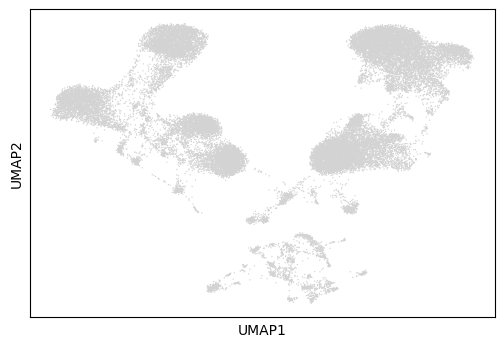

In [10]:
# plot UMAPs of rna cells based only on rna markers with protein correspondence
sc.pp.neighbors(rna_shared, n_neighbors=15)
sc.tl.umap(rna_shared)
sc.pl.umap(rna_shared) # , color=['celltype.l1','celltype.l2']

In [11]:
rna_shared = rna_shared.X.copy()

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


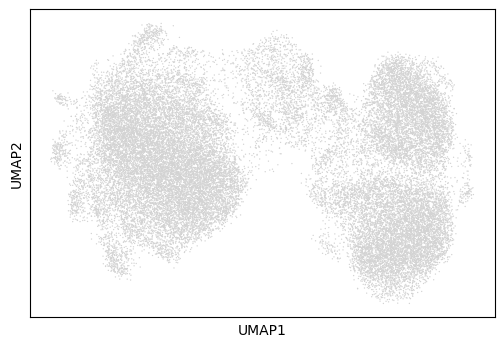

In [12]:
# process protein_shared
sc.pp.normalize_total(protein_shared, target_sum=target_sum)
sc.pp.log1p(protein_shared)
sc.pp.scale(protein_shared)

# plot UMAPs of protein cells based only on protein markers with rna correspondence

sc.pp.neighbors(protein_shared, n_neighbors=15)
sc.tl.umap(protein_shared)
sc.pl.umap(protein_shared)

In [13]:
protein_shared = protein_shared.X.copy()

In [14]:
# # process all RNA features
# sc.pp.normalize_total(rna_adata)
# sc.pp.log1p(rna_adata)
# sc.pp.highly_variable_genes(rna_adata)
# # only retain highly variable genes
# rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()
# sc.pp.scale(rna_adata)

# # plot UMAPs of rna cells based on all active rna markers

# sc.pp.neighbors(rna_adata, n_neighbors=15)
# sc.tl.umap(rna_adata)
# sc.pl.umap(rna_adata, color=['celltype.l1','celltype.l2'])

In [15]:
# # process all protein features
# sc.pp.normalize_total(protein_adata)
# sc.pp.log1p(protein_adata)
# sc.pp.scale(protein_adata)

# # plot UMAPs of protein cells based on all active protein markers

# sc.pp.neighbors(protein_adata, n_neighbors=15)
# sc.tl.umap(protein_adata)
# sc.pl.umap(protein_adata, color=['celltype.l1','celltype.l2'])

In [16]:
# make sure no feature is static
rna_active = rna_adata_pool_subset.X
protein_active = protein_adata_intersect.X
rna_active = rna_active[:, rna_active.std(axis=0) > 1e-5]
protein_active = protein_active[:, protein_active.std(axis=0) > 1e-5]

In [17]:
# call constructor for Fusor object
# which is the main object for running MaxFuse pipeline
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    shared_arr2=protein_shared,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=None,
    labels2=None
)

In [18]:
fusor.split_into_batches(
    max_outward_size=5000,
    matching_ratio=3,
    metacell_size=2,
    verbose=True
)

The first data is split into 3 batches, average batch size is 10882, and max batch size is 10884.
The second data is split into 2 batches, average batch size is 16324, and max batch size is 16324.
Batch to batch correspondence is:
  ['0<->0', '0<->1', '1<->0', '1<->1', '2<->0', '2<->1'].


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

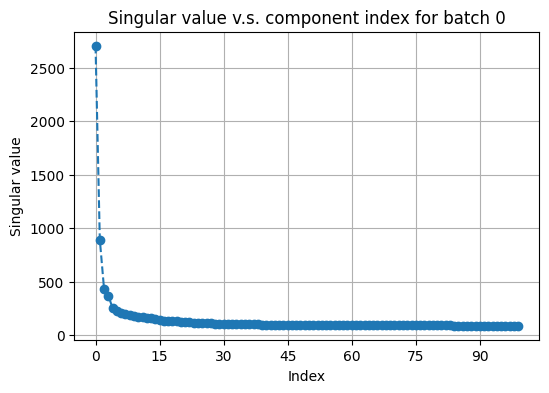

In [19]:
# plot top singular values of avtive_arr1 on a random batch
fusor.plot_singular_values(
    target='active_arr1',
    n_components=None # can also explicitly specify the number of components
)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

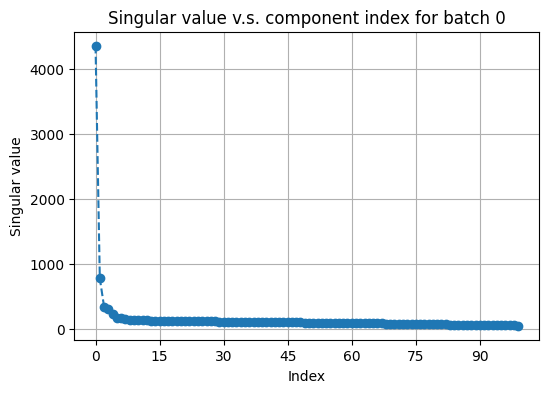

In [20]:
# plot top singular values of avtive_arr2 on a random batch
fusor.plot_singular_values(
    target='active_arr2',
    n_components=None
)

In [21]:
fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=30,
    svd_components2=30,
    resolution1=2,
    resolution2=2,
    # if two resolutions differ less than resolution_tol
    # then we do not distinguish between then
    resolution_tol=0.1,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Now at batch 1...
Metacell clustering finished!
Now at batch 2...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Now at batch 1...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Now at batch 1...
Graph clustering finished!


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 2'}, xlabel='Index', ylabel='Singular value'>)

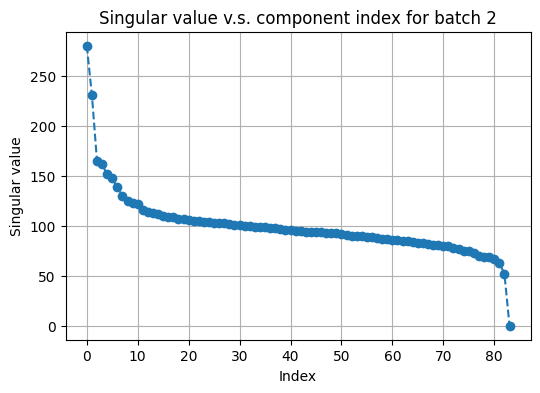

In [22]:
# plot top singular values of shared_arr1 on a random batch
fusor.plot_singular_values(
    target='shared_arr1',
    n_components=None,
)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

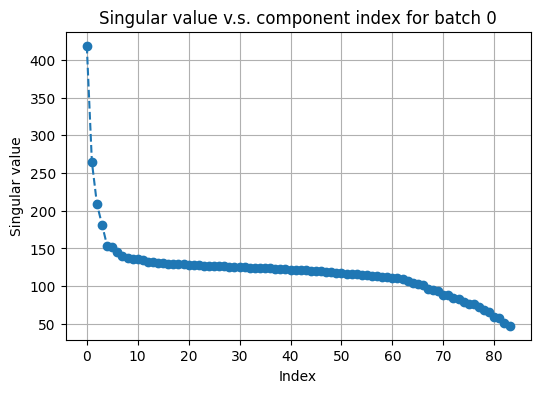

In [23]:
# plot top singular values of shared_arr2 on a random batch
fusor.plot_singular_values(
    target='shared_arr2',
    n_components=None
)

In [24]:
fusor.find_initial_pivots(
    wt1=0.7, wt2=0.7,
    svd_components1=35, svd_components2=70
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 1<->0...
Now at batch 1<->1...
Now at batch 2<->0...
Now at batch 2<->1...
Done!


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Canonical correlation v.s. component index for batch 1<->1'}, xlabel='Index', ylabel='Canonical correlation'>)

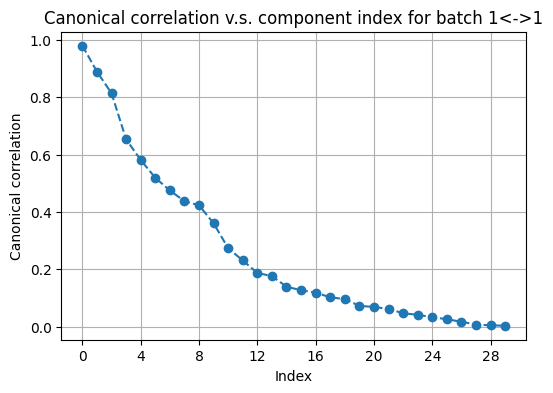

In [25]:
# plot top canonical correlations in a random batch
fusor.plot_canonical_correlations(
    svd_components1=30,
    svd_components2=30,
    cca_components=30
)

In [26]:
fusor.refine_pivots(
    wt1=0.7, wt2=0.7,
    svd_components1=30, svd_components2=30,
    cca_components=20,
    n_iters=3,
    randomized_svd=False,
    svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 1<->0...
Now at batch 1<->1...
Now at batch 2<->0...
Now at batch 2<->1...
Done!


In [27]:
fusor.filter_bad_matches(target='pivot', filter_prop=0.3)

Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 1<->0...
Now at batch 1<->1...
Now at batch 2<->0...
Now at batch 2<->1...
22850/32646 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
27167/32648 cells in arr1 are selected as pivots.
14458/32648 cells in arr2 are selected as pivots.
Done!


In [28]:
pivot_matching = fusor.get_matching(target='pivot')

In [29]:
# We can inspect the first pivot pair.
[pivot_matching[0][0], pivot_matching[1][0], pivot_matching[2][0]]

[497, 1, 0.7652636493436289]

In [30]:
rna_cca, protein_cca = fusor.get_embedding(
    active_arr1=fusor.active_arr1,
    active_arr2=fusor.active_arr2
)

In [31]:
dim_use = 15 # dimensions of the CCA embedding to be used for UMAP etc

mf.metrics.get_foscttm(
    dist=mf.utils.cdist_correlation(rna_cca[:,:dim_use], protein_cca[:,:dim_use]),
    true_matching='identity'
)

0.16998608988402636

In [32]:
cca_adata = ad.AnnData(
    np.concatenate((rna_cca[:,:dim_use], protein_cca[:,:dim_use]), axis=0),
    dtype=np.float32
)
cca_adata.obs['data_type'] = ['rna'] * rna_cca.shape[0] + ['protein'] * protein_cca.shape[0]

/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


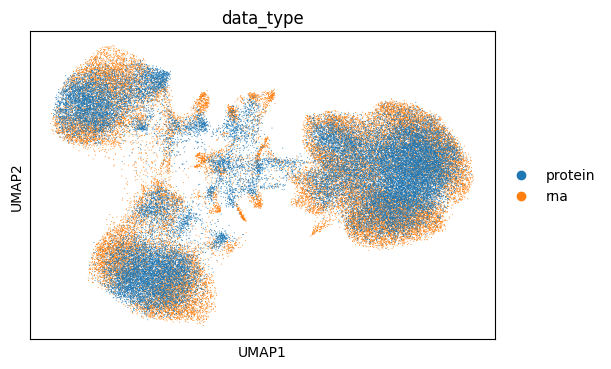

In [33]:
sc.pp.neighbors(cca_adata, n_neighbors=15)
sc.tl.umap(cca_adata)
sc.pl.umap(cca_adata, color='data_type')

In [34]:
cca_adata.obs.value_counts()

data_type
protein      32648
rna          32648
dtype: int64

In [35]:
fusor.propagate(
    svd_components1=30,
    svd_components2=30,
    wt1=0.7,
    wt2=0.7,
)

Now at batch 0<->0...


Now at batch 0<->1...
Now at batch 1<->0...
Now at batch 1<->1...
Now at batch 2<->0...
Now at batch 2<->1...
Done!


In [36]:
fusor.filter_bad_matches(
    target='propagated',
    filter_prop=0
)

Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 1<->0...
Now at batch 1<->1...
Now at batch 2<->0...
Now at batch 2<->1...
84890/84890 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!


In [37]:
full_matching = fusor.get_matching(order=(2, 1), target='full_data')

In [38]:
pd.DataFrame(list(zip(full_matching[0], full_matching[1], full_matching[2])),
             columns = ['mod1_indx', 'mod2_indx', 'score'])
# columns: cell idx in mod1, cell idx in mod2, and matching scores

,mod1_indx,mod2_indx,score
0,497,1,0.765264
1,1483,4,0.797604
2,12295,7,0.852197
3,12506,9,0.692083
4,31307,11,0.319048
...,...,...,...
32643,32227,32639,0.557640
32644,13932,32640,0.639321
32645,13153,32641,0.627990
32646,14290,32642,0.614633


In [40]:
rna_cca.shape, protein_cca.shape

((32648, 20), (32648, 20))

In [45]:
cca_adata.obsm["X_umap"].shape

(65296, 2)

In [ ]:
# call constructor for Fusor object
# which is the main object for running MaxFuse pipeline
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    shared_arr2=protein_shared,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=None,
    labels2=None
)

In [ ]:
fusor.split_into_batches(
    max_outward_size=5000,
    matching_ratio=3,
    metacell_size=2,
    verbose=True
)

The first data is split into 3 batches, average batch size is 10882, and max batch size is 10884.
The second data is split into 2 batches, average batch size is 16324, and max batch size is 16324.
Batch to batch correspondence is:
  ['0<->0', '0<->1', '1<->0', '1<->1', '2<->0', '2<->1'].


## clustering and visualization

In [47]:
# Generate five different random subsample datasets from the original dataset
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


random.seed(42)

num_cells = rna_shared.shape[0]
subsample_size = 10000
subsample_datasets = []

for i in range(5):
    subsample_indices = random.sample(range(num_cells), subsample_size)
    subsample_rna_shared = rna_shared[subsample_indices, :].copy()
    subsample_protein_shared = protein_shared[subsample_indices, :].copy()
    subsample_rna_active = rna_active[subsample_indices, :].copy()
    subsample_protein_active = protein_active[subsample_indices, :].copy()
    subsample_data = mf.model.Fusor(
        shared_arr1=subsample_rna_shared,
        shared_arr2=subsample_protein_shared,
        active_arr1=subsample_rna_active,
        active_arr2=subsample_protein_active,
        labels1=None,
        labels2=None
    )
    subsample_datasets.append(subsample_data)

In [48]:
silhouette_score_dict = {}
for i, subset_mdata in enumerate(subsample_datasets):
    fusor = subset_mdata
    fusor.split_into_batches(
        max_outward_size=5000,
        matching_ratio=3,
        metacell_size=2,
        verbose=True
    )
    fusor.construct_graphs(
        n_neighbors1=15,
        n_neighbors2=15,
        svd_components1=30,
        svd_components2=30,
        resolution1=2,
        resolution2=2,
        # if two resolutions differ less than resolution_tol
        # then we do not distinguish between then
        resolution_tol=0.1,
        verbose=True
    )
    fusor.find_initial_pivots(
        wt1=0.7, wt2=0.7,
        svd_components1=35, svd_components2=70
    )
    fusor.refine_pivots(
        wt1=0.7, wt2=0.7,
        svd_components1=30, svd_components2=30,
        cca_components=20,
        n_iters=3,
        randomized_svd=False,
        svd_runs=1,
        verbose=True
    )
    fusor.filter_bad_matches(target='pivot', filter_prop=0.3)
    rna_cca, protein_cca = fusor.get_embedding(
        active_arr1=fusor.active_arr1,
        active_arr2=fusor.active_arr2
    )
    silhouette_scores = []
    for k in range(2, 30):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(rna_cca)
        silhouette_scores.append(silhouette_score(rna_cca, labels))
    silhouette_score_dict[f"Subset_{i}"] = silhouette_scores

The first data is split into 1 batches, average batch size is 10000, and max batch size is 10000.
The second data is split into 1 batches, average batch size is 10000, and max batch size is 10000.
Batch to batch correspondence is:
  ['0<->0'].
Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...


Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Graph clustering finished!
Now at batch 0<->0...
Done!
Now at batch 0<->0...
Done!
Begin filtering...
Now at batch 0<->0...
3498/4997 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
6980/10000 cells in arr1 are selected as pivots.
3498/10000 cells in arr2 are selected as pivots.
Done!


/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/

The first data is split into 1 batches, average batch size is 10000, and max batch size is 10000.
The second data is split into 1 batches, average batch size is 10000, and max batch size is 10000.
Batch to batch correspondence is:
  ['0<->0'].
Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Graph clustering finished!
Now at batch 0<->0...
Done!
Now at batch 0<->0...
Done!
Begin filtering...
Now at batch 0<->0...
3500/5000 pairs of matched cells remain a

/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/

The first data is split into 1 batches, average batch size is 10000, and max batch size is 10000.
The second data is split into 1 batches, average batch size is 10000, and max batch size is 10000.
Batch to batch correspondence is:
  ['0<->0'].
Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Graph clustering finished!
Now at batch 0<->0...
Done!
Now at batch 0<->0...
Done!
Begin filtering...
Now at batch 0<->0...
3491/4988 pairs of matched cells remain a

/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/

The first data is split into 1 batches, average batch size is 10000, and max batch size is 10000.
The second data is split into 1 batches, average batch size is 10000, and max batch size is 10000.
Batch to batch correspondence is:
  ['0<->0'].
Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Graph clustering finished!
Now at batch 0<->0...
Done!
Now at batch 0<->0...
Done!
Begin filtering...
Now at batch 0<->0...
3499/4999 pairs of matched cells remain a

/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/

The first data is split into 1 batches, average batch size is 10000, and max batch size is 10000.
The second data is split into 1 batches, average batch size is 10000, and max batch size is 10000.
Batch to batch correspondence is:
  ['0<->0'].
Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Graph clustering finished!
Now at batch 0<->0...
Done!
Now at batch 0<->0...
Done!
Begin filtering...
Now at batch 0<->0...
3503/5004 pairs of matched cells remain a

/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/

In [49]:
import pickle

with open(f"{save_path}maxfuse_silhouette_scores_dict.pkl", "wb") as f:
    pickle.dump(silhouette_score_dict, f)

In [50]:
tmp = pickle.load(open(f"{save_path}maxfuse_silhouette_scores_dict.pkl", "rb"))
tmp.keys()

dict_keys(['Subset_0', 'Subset_1', 'Subset_2', 'Subset_3', 'Subset_4'])